# HW04: RDD and Diff-in-Diff (due 24th October 23:59)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [1]:
!pip install rdrobust

In [2]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [49]:
df = pd.read_stata('data/HW04_data_rdd.dta')

/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_86071/2619628620.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [50]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
df_labels

/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_86071/1581965592.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [51]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 

<center>$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$</center>

In [57]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col
formula = 'pcorrupt ~ first'

model = smf.ols(formula,data=df)
ols1 = model.fit(cov_type='HC3')
summary = summary_col([ols1], stars=True, float_format='%0.2f')
print(summary)



               pcorrupt
-----------------------
Intercept      0.07*** 
               (0.01)  
first          -0.02** 
               (0.01)  
R-squared      0.01    
R-squared Adj. 0.01    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


**What could be some sources of bias, namely, variables that act as confounder?**

Variables that could act as confounders include p_secundario (% of citizens who had secondary education), uf (state), and exp_prefeito (mayor experience). These variables can be confounders because they have the potential to influence both the treatment (seeking reelection) and outcome (corruption). p_secundario could influence the tendency to seek reelection because having more highly or lowly educated citizens can have an effect on the approval ratings of a first-term mayor and influence whether a mayor thinks that they can get away with corruption. The state can also impact reelection and corruption because certain states surely have different proportions of mayors who run for reelection or who are corrupt. Finally, the experience of the candidate can influence whether they think they should run for a second term and whether they've been exposed to or want to attempt corruption.


In [58]:
## run the regression above adding the variables that may act as a confounder
formula = 'pcorrupt ~ first + p_secundario + uf + exp_prefeito'

model = smf.ols(formula,data=df)
ols2 = model.fit(cov_type='HC3')
summary = summary_col([ols1], stars=True, float_format='%0.2f')


               pcorrupt
-----------------------
Intercept      0.07*** 
               (0.01)  
first          -0.02** 
               (0.01)  
R-squared      0.01    
R-squared Adj. 0.01    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


In [59]:
## display the results 
print(summary)



               pcorrupt
-----------------------
Intercept      0.07*** 
               (0.01)  
first          -0.02** 
               (0.01)  
R-squared      0.01    
R-squared Adj. 0.01    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

In [ ]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt
rdplot(...)

In [ ]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
covs = pd.concat([df.dropna(subset=['winning_margin'])[[...]], axis=1)
print(rdrobust(...))

**Interpret the coefficient**

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [27]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
df_labels

/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_86071/1792503655.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'observ': 'block id',
 'barrio': 'neighborhood',
 'calle': 'street',
 'altura': 'street numbering',
 'institu1': 'dummy Jewish institution in the block',
 'institu3': 'dummy Jewish institution one block away',
 'distanci': 'block distance to closest institution',
 'edpub': 'dummy public building/embassy',
 'estserv': 'dummy gas station',
 'banco': 'dummy bank',
 'totrob': 'car theft',
 'mes': 'month',
 'inst3_1': '',
 'month5': '',
 'post': '',
 'inst1p': '',
 'inst3_1p': ''}

In [4]:
df.head()

,observ,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,mes,inst3_1,month5,post,inst1p,inst3_1p
0,870.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,851.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,843.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,796.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
4,790.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

<center>$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$</center>

In [39]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = smf.ols(formula='totrob ~ inst1p',data=df)
regression1 = ols1.fit()

**Why this estimate CANNOT be interpreted as causal?**

An OLS determines correlation between 2 variables, which is distinct from causation. 

[0. 1.]
[ 4.  5.  6.  7.  8.  9. 10. 11. 12.]
[ 4.  5.  6.  7.  8.  9. 10. 11. 12.]
333
7551


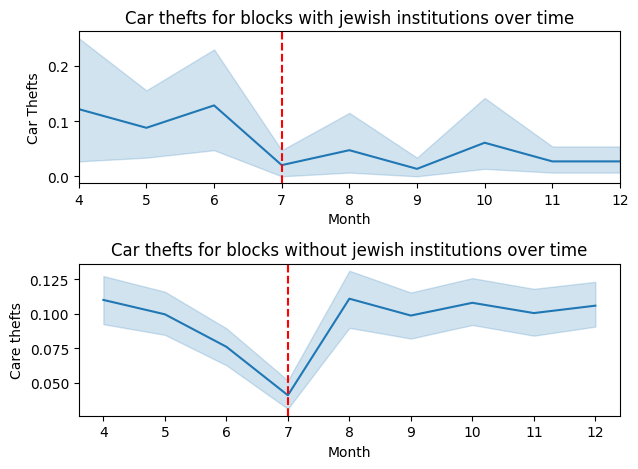

In [24]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt
print(df['institu1'].unique())
jewish = df[df['institu1'] == 1]
non_jewish = df[df['institu1'] == 0]
print(jewish['mes'].unique())
print(non_jewish['mes'].unique())
print(jewish.shape[0])
print(non_jewish.shape[0])



plt.subplot(2,1,1)
sns.lineplot(x='mes',y='totrob',data=jewish)
plt.title('Car thefts for blocks with jewish institutions over time')
plt.xlabel('Month')
plt.ylabel('Car Thefts')
plt.xlim(4, 12)
plt.axvline(x=7, color='red', linestyle='--', label='Terrorist Attack')



plt.subplot(2,1,2)
plt.xlabel('Month')
plt.ylabel('Care thefts')
plt.title('Car thefts for blocks without jewish institutions over time')
sns.lineplot(x='mes',y='totrob',data=non_jewish)
plt.axvline(x=7, color='red', linestyle='--', label='Terrorist Attack')


plt.tight_layout()





**Does the parallel trend assumption hold?**

Yes. This is because both sets of data are trending downwards before the time of the attack. Even though they don't follow each other's trend exactly, they are both approximately responding to the month variable the same. 

In [35]:
##Run the regression above including month and block fixed effects
from linearmodels import PanelOLS
print(df.columns)
panel_data = df.set_index(['observ', 'mes'])

did = PanelOLS.from_formula('totrob ~ inst1p + EntityEffects + TimeEffects',data=panel_data)
result2 = did.fit()

Index(['observ', 'barrio', 'calle', 'altura', 'institu1', 'institu3',
       'distanci', 'edpub', 'estserv', 'banco', 'totrob', 'mes', 'inst3_1',
       'month5', 'post', 'inst1p', 'inst3_1p'],
      dtype='object')


In [48]:
##show the results from both regressions
print(regression1.summary())
print(result2.summary)

                            OLS Regression Results                            
Dep. Variable:                 totrob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.82
Date:                Sat, 21 Oct 2023   Prob (F-statistic):            0.00101
Time:                        15:37:16   Log-Likelihood:                 4.5306
No. Observations:                7884   AIC:                            -5.061
Df Residuals:                    7882   BIC:                             8.884
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0943      0.003     34.222      0.0

**Compare and interpret the results**

The first regression shows an r-squared value of 0.0021 and f-statistic of 
10.82. This means that the according to this regression, the presence of a Jewish institution harly explains the amount of car thefts at all. However, the large f-statistic shows that the model itself is highly significant.

The first model parameters yielded an equation of totrob = .09 - .05 (inst1p). The t statistic of the intercept is large (34.22), which is not important in this context because we are more interested in the slope. The slope is -0.0592 with a t statistic of -3.29, which is outside the range of -2:2 so it is statistically significant. 

So, while the t statistics are high, the model shows that the presence of a Jewish institution does not explain the crime very well. 

The second regression shows an r-squared value of 0.0013 and f-statistic of 
8.95. This means that the according to this regression, the presence of a Jewish institution harly explains the amount of car thefts at all. However, the large f-statistic shows that the model itself is highly significant.  Interestingly, shown by the r squared value being smaller and the f-statistic being smaller than the original regression, this means that this model does not support a correlation as well as the first model. 

The second model parameters yielded an equation of totrob = -.0775(inst1p). The slope is -0.0775 with a t statistic of -2.99, which is outside the range of -2:2 so it is statistically significant.

So, while the second model tried to control for some fixed effects, it did not show a stronger correlation.